# Credit Momentum

Societe Generale: Trend-following and mean-reversion strategies on credit indices

# Packages

In [5]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/CreditMomentum/root/src")
from SignalGenerator import SignalGenerator

# Get Data

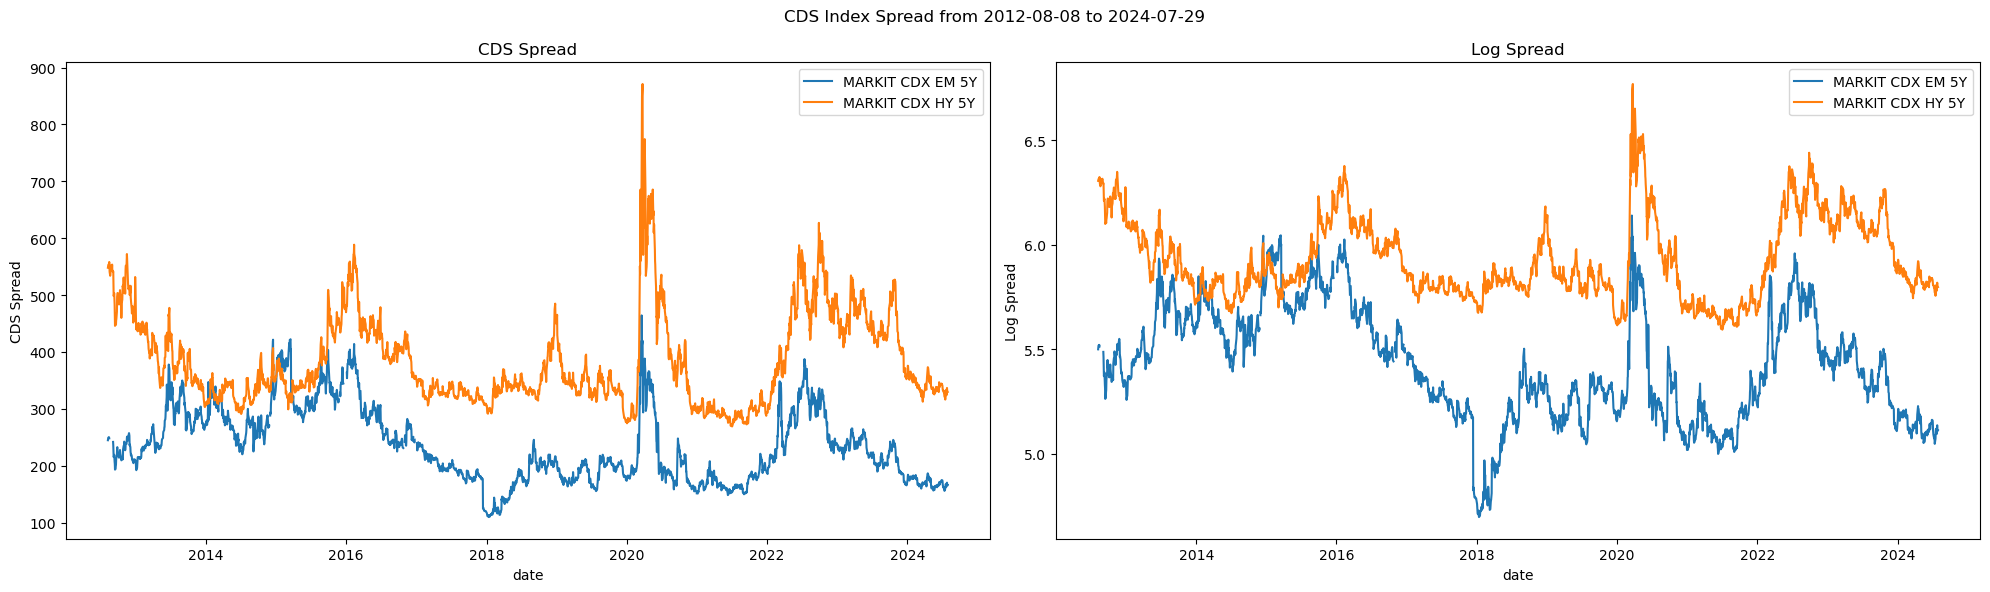

In [63]:
def plot_spread() -> plt.Figure: 

    df_longer = (SignalGenerator().get_cds().query(
        "variable == 'SPRD'").
        drop(columns = ["variable", "maturity"]).
        assign(log_val = lambda x: np.log(x.value)).
        rename(columns = {"value": "spread"}).
        melt(id_vars = ["date", "unique_name"]))
    
    variables = df_longer.variable.drop_duplicates().to_list()
    renamer = {
        "spread" : "CDS Spread",
        "log_val": "Log Spread"}
    
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_longer.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            rename(columns = {"unique_name": ""}).
            pivot(index = "date", columns = "", values = "value").
            plot(
                ax     = ax,
                ylabel = renamer[variable],
                title  = renamer[variable]))
    
    fig.suptitle("CDS Index Spread from {} to {}".format(
        df_longer.date.min(),
        df_longer.date.max()))

    plt.tight_layout()

plot_spread()

In [17]:
def _get_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(rtn = lambda x: x.value.pct_change()).
        dropna())

def get_data() -> pd.DataFrame: 
    
    df_raw = CreditDataPrep().get_data()

    df_log_spread = (df_raw.query(
        "group_short == 'Spread'").
        assign(log_spread = lambda x: np.log(x.value)))

    df_index = (df_raw.query(
        "asset_class == 'CDS' & group_short == 'Index'").
        drop(columns = ["group_short", "asset_class"]).
        assign(group_name = lambda x: x.security.str.split(" ").str[1]).
        groupby("security").
        apply(_get_rtn).
        reset_index(drop = True))
    
    return df_log_spread, df_index

df_log_spread, df_index = get_data()

AttributeError: 'SignalGenerator' object has no attribute 'get_data'

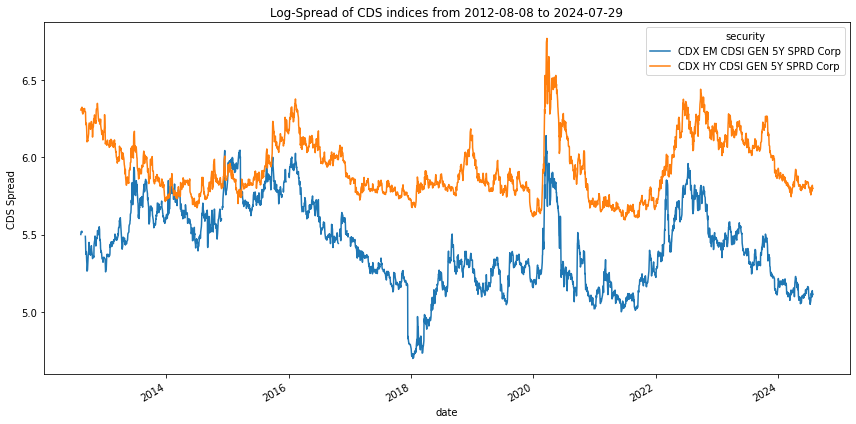

In [3]:
def plot_log_spread(df_log_spread: pd.DataFrame) -> plt.Figure: 
    
    (df_log_spread[
        ["date", "security", "log_spread"]].
        pivot(index = "date", columns = "security", values = "log_spread").
        plot(
            ylabel = "CDS Spread",
            figsize = (12,6),
            title = "Log-Spread of CDS indices from {} to {}".format(
                df_log_spread.date.min().date(),
                df_log_spread.date.max().date())))
    
    plt.tight_layout()
    
plot_log_spread(df_log_spread)

They define the following Trend-Following Strategy <br>
1. 1m rolling $\beta$ of Smooth Component
2. 3m rolling $\beta$ of Smooth Component
3. 1m rolling $\beta$ of Mean-Reverting Component
4. 3m rolling $\beta$ of Mean-Reverting Component


Start by building the signal

In [6]:
def _regression(df: pd.DataFrame, lookback_window: int) -> pd.DataFrame: 
    
    df_tmp = (df.sort_values(
        "date").
        assign(lag_value = lambda x: x.value.shift(lookback_window)).
        dropna())
    
    regression = (RollingOLS(
        endog = df_tmp.value,
        exog = sm.add_constant(df_tmp.lag_value),
        window = lookback_window).
        fit())
    
    df_out = (regression.params.rename(
        columns = {
            "const": "alpha",
            "lag_value": "beta"}).
        assign(
            lookback = lookback_window,
            date = lambda x: df_tmp.date,
            lag_beta = lambda x: x.beta.shift()).
        dropna().
        merge(right = df_tmp, how = "inner", on = ["date"]))
    
    return df_out

def _get_rolling_regression(df: pd.DataFrame, lookback_windows: list) -> pd.DataFrame: 
    
    df_out = (pd.concat(
        [_regression(df, lookback_window) 
         for lookback_window in lookback_windows]))
    
    return df_out

def get_rolling_regression(df: pd.DataFrame, lookback_windows: list = [20, 60]) -> pd.DataFrame: 

    df_regression = (df_kalman.assign(
        group_var = lambda x: x.security + " " + x.variable).
        groupby("group_var").
        apply(_get_rolling_regression, lookback_windows).
        reset_index(drop = True).
        drop(columns = ["group_var"]))
    
    return df_regression

df_regression = get_rolling_regression(df_kalman)

Then they use the sign of the beta as an indicator for buying protection. Start by building the signal first. 

In [7]:
def apply_signal(df_regression: pd.DataFrame, df_index: pd.DataFrame) -> pd.DataFrame: 
    
    df_regress_tmp = (df_regression.assign(
        signal = lambda x: np.sign(x.lag_beta))
        [["date", "signal", "security", "variable", "lookback"]])

    df_index_prep = (df_index[
        ["date", "group_name", "security", "rtn"]].
        assign(renamer = lambda x: x.security.str.split("PRC").str[0]).
        drop(columns = ["security"]).
        rename(columns = {"group_name": "security"}))

    df_prep = (df_index_prep.merge(
        right = df_regress_tmp, how = "inner", on = ["date", "security"]).
        assign(signal_rtn = lambda x: x.signal * x.rtn))
    
    return df_prep

df_signal = apply_signal(df_regression, df_index)

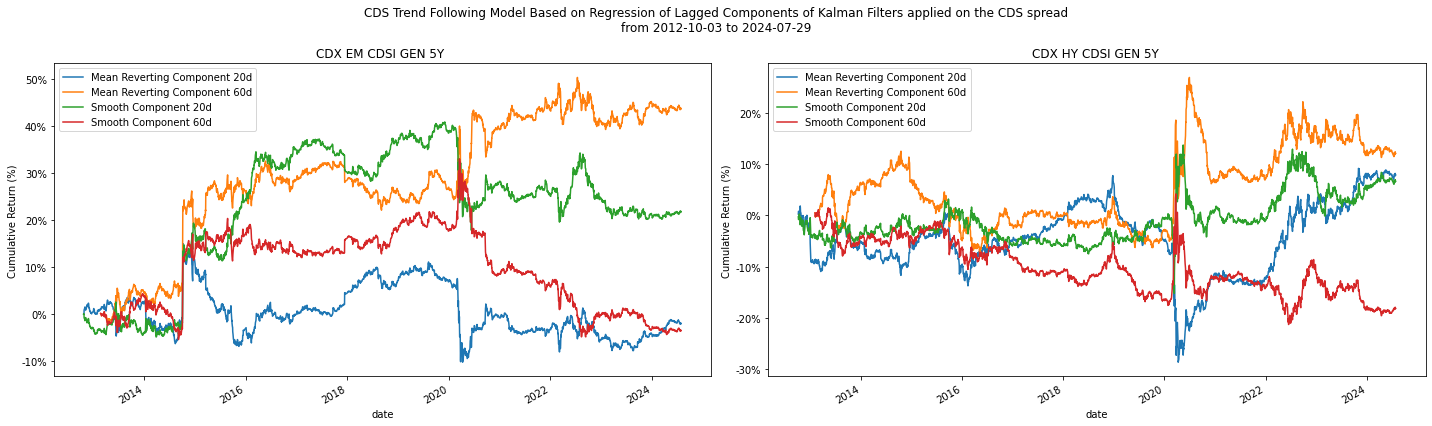

In [8]:
def plot_cumulative_return(df_signal: pd.DataFrame) -> plt.Figure: 

    renamer = {
        "mean_reversion": "Mean Reverting Component",
        "smooth": "Smooth Component"}

    indices = df_signal.renamer.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(indices), figsize = (20,6))

    for index, ax in zip(indices, axes.flatten()): 

        (df_signal.query(
            "renamer == @index").
            replace(renamer).
            assign(strat_name = lambda x: x.variable + " " + x.lookback.astype(str) + "d")
            [["strat_name", "signal_rtn", "date"]].
            pivot(index = "date", columns = "strat_name", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax = ax,
                ylabel = "Cumulative Return (%)",
                title = index))

        ax.legend(title = "")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

    fig.suptitle("CDS Trend Following Model Based on Regression of Lagged Components of Kalman Filters applied on the CDS spread\nfrom {} to {}".format(
        df_signal.date.min().date(),
        df_signal.date.max().date()))

    plt.tight_layout()
    
plot_cumulative_return(df_signal)

They use an adaptive method based on picking the maximized rolling 1 month sharpe. First start by getting the 1 month rolling sharpe.

In [9]:
def _get_one_month_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.sort_values(
        "date").
        assign(
            sharpe = lambda x: x.signal_rtn.rolling(window = 20).mean() / x.signal_rtn.rolling(window = 20).std() * np.sqrt(252 / 12),
            lag_sharpe = lambda x: x.sharpe.shift()).
        dropna())
    
    return df_tmp

def get_one_month_sharpe(df_signal: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_signal.assign(
        group_var = lambda x: x.security + " " + x.variable + " " + x.lookback.astype(str)).
        groupby("group_var").
        apply(_get_one_month_sharpe).
        reset_index(drop = True))
    
    return df_out

df_sharpe = get_one_month_sharpe(df_signal)

Plot rolling sharpes

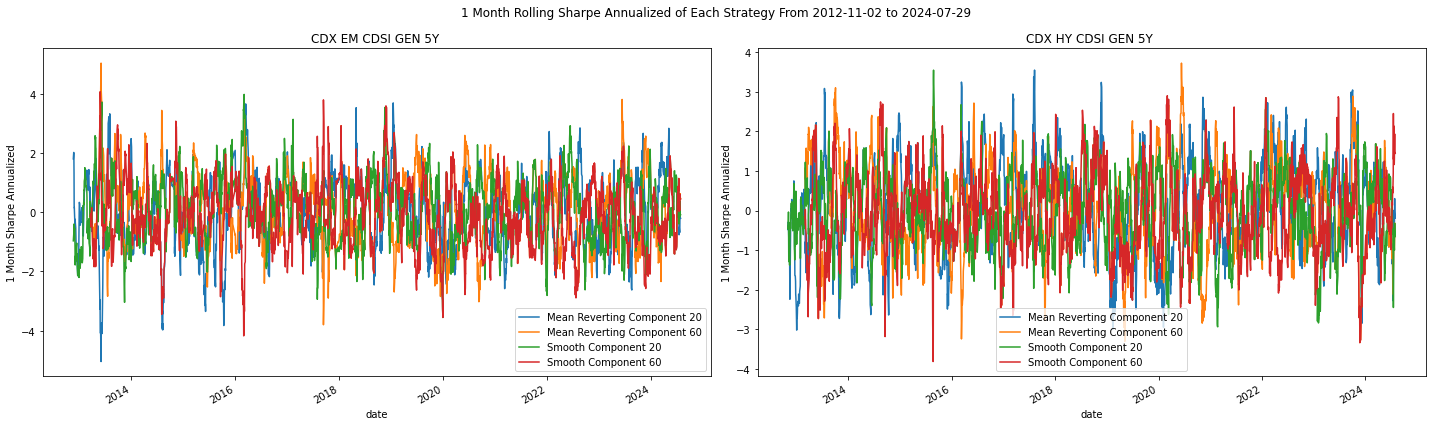

In [10]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "mean_reversion": "Mean Reverting Component",
        "smooth": "Smooth Component"}

    indices = df_signal.renamer.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(indices), figsize = (20,6))

    for index, ax in zip(indices, axes.flatten()): 

        (df_sharpe.query(
            "renamer == @index").
            replace(renamer).
            assign(strat = lambda x: x.variable + " " + x.lookback.astype(str))
            [["strat", "date", "sharpe"]].
            pivot(index = "date", columns = "strat", values = "sharpe").
            plot(
                ax = ax,
                ylabel = "1 Month Sharpe Annualized",
                title = index))

        ax.legend(title = "")

    fig.suptitle("1 Month Rolling Sharpe Annualized of Each Strategy From {} to {}".format(
        df_sharpe.date.min().date(),
        df_sharpe.date.max().date()))

    plt.tight_layout()
    
plot_sharpe(df_sharpe)

Now go through each day and pick the signal that has the max lagged sharpe

In [11]:
def _get_max(df: pd.DataFrame) -> pd.DataFrame: return(df.query("lag_sharpe == lag_sharpe.max()"))

def _get_max_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out =(df.groupby(
        "date").
        apply(_get_max))
    
    return df_out

def get_max_sharpe(df_sharpe: pd.DataFrame) -> pd.DataFrame: 

    df_max_sharpe = (df_sharpe.groupby(
        "security").
        apply(_get_max_sharpe).
        reset_index(drop = True))
    
    return df_max_sharpe

df_max_sharpe = get_max_sharpe(df_sharpe)

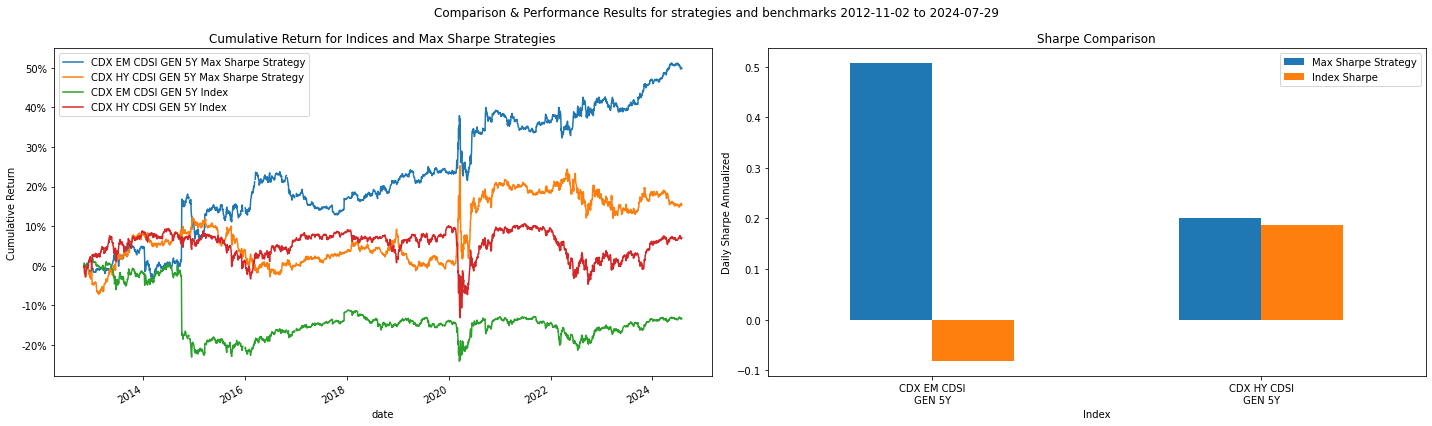

In [12]:
def plot_cumulative_comparitive_returns(df_max_sharpe: pd.DataFrame, df_index: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    df_rtn = (df_max_sharpe[
        ["date", "renamer", "signal_rtn"]].
        groupby(["date", "renamer"]).
        head(1).
        pivot(index = "date", columns = "renamer", values = "signal_rtn"))

    df_strat_rtn = (df_rtn.mean() / df_rtn.std() * np.sqrt(252)).to_frame(name = "Max Sharpe Strategy")

    df_index_rtn = (df_index.assign(
        renamer = lambda x: x.security.str.split("PRC").str[0])
        [["date", "renamer", "rtn"]].
        pivot(index = "date", columns = "renamer", values ="rtn"))

    df_index_sharpe = (df_index_rtn.mean() / df_index_rtn.std() * np.sqrt(252)).to_frame(name = "Index Sharpe")

    df_signal_renamer = (df_rtn.reset_index().melt(
        id_vars = "date").
        assign(renamer = lambda x: x.renamer + "Max Sharpe Strategy").
        pivot(index = "date", columns = "renamer", values = "value"))

    df_index_renamer = (df_index_rtn.reset_index().melt(
        id_vars = "date").
        assign(renamer = lambda x: x.renamer + "Index").
        pivot(index = "date", columns = "renamer", values = "value"))

    df_plot = (df_signal_renamer.merge(
        right = df_index_renamer, how = "inner", on = ["date"]).
        apply(lambda x: np.cumprod(1 + x) - 1))

    (df_plot.plot(
        ax = axes[0],
        ylabel = "Cumulative Return",
        title = "Cumulative Return for Indices and Max Sharpe Strategies"))

    (df_strat_rtn.merge(
        right = df_index_sharpe, how = "inner", on = ["renamer"]).
        reset_index().
        assign(renamer = lambda x: x.renamer.str.replace("CDSI", "CDSI\n")).
        rename(columns = {"renamer": "Index"}).
        set_index("Index").
        plot(
            ax = axes[1],
            kind = "bar",
            ylabel = "Daily Sharpe Annualized",
            title = "Sharpe Comparison"))

    axes[0].legend(title = "")
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    axes[1].tick_params(axis = "x", rotation = 0)

    fig.suptitle("Comparison & Performance Results for strategies and benchmarks {} to {}".format(df_plot.index.min().date(), df_plot.index.max().date()))
    plt.tight_layout()
    
plot_cumulative_comparitive_returns(df_max_sharpe, df_index)

They include a mean reversion strategy that uses a z-score cuttoff of 1.6 and shorts z-score. 

In [13]:
def prep_mean_reverting(df_kalman: pd.DataFrame, df_index: pd.DataFrame) -> pd.DataFrame: 

    df_mean_reverting = (df_kalman.query(
        "variable == 'mean_reversion'").
        drop(columns = ["log_spread", "variable"]))

    df_rtn = (df_index.drop(
        columns = ["security", "value"]).
        rename(columns = {"group_name": "security"}))

    df_stats = (df_mean_reverting.drop(
        columns = ["date"]).
        groupby("security").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_val",
            "std": "std_val"}))

    df_combined = (df_mean_reverting.merge(
        right = df_rtn, how = "inner", on = ["date", "security"]).
        merge(right = df_stats, how = "inner", on = ["security"]))
    
    return df_combined

df_mean_reverting = prep_mean_reverting(df_kalman, df_index)

In [14]:
def _generate_mean_reverting_signal(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            zscore = lambda x: (x.value - x.mean_val) / x.std_val,
            lag_zscore = lambda x: x.zscore.shift(),
            abs_zscore = lambda x: np.abs(x.lag_zscore),
            zscore_sign = lambda x: np.sign(x.abs_zscore)).
        dropna())
    
    return df_out

def generate_mean_reverting_signal(df_mean_reverting: pd.DataFrame) -> pd.DataFrame: 

    df_mean_reverting_rtns = (df_mean_reverting.groupby(
        "security").
        apply(_generate_mean_reverting_signal).
        reset_index(drop = True).
        query("abs_zscore > 1.6").
        assign(signal_rtn = lambda x: x.zscore_sign * x.rtn))
    
    return df_mean_reverting_rtns

df_mean_reverting_rtns = generate_mean_reverting_signal(df_mean_reverting)

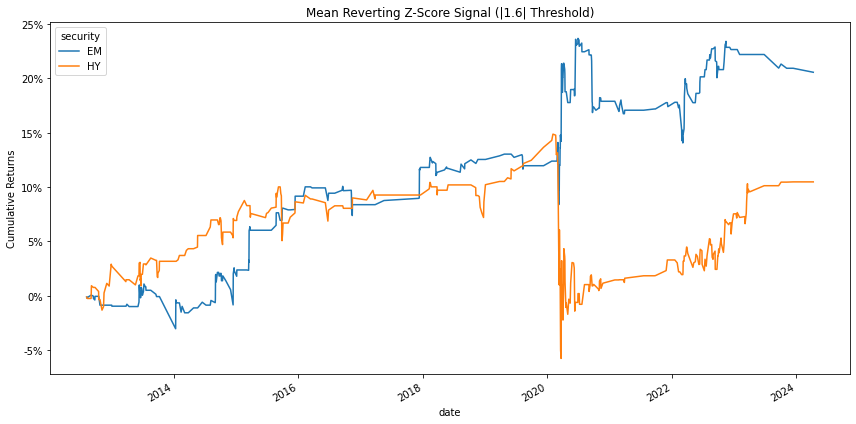

In [15]:
def plot_mean_reverting_rtns(df_mean_reverting_rtns: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_mean_reverting_rtns[
        ["date", "security", "signal_rtn"]].
        pivot(index = "date", columns = "security", values = "signal_rtn").
        fillna(0).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes,
            title = "Mean Reverting Z-Score Signal (|1.6| Threshold)",
            ylabel = "Cumulative Returns"))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    plt.tight_layout()
    
plot_mean_reverting_rtns(df_mean_reverting_rtns)

Based on graphs that the authors present it appears that they find z-scores based on the whole sample rather than using a rolling method. In this case the z-score will be 30d.

In [16]:
def _get_rolling_zscore(df: pd.DataFrame, lookback: int) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(z_score = lambda x: ((x.value - x.value.rolling(window = lookback).mean()) / x.value.rolling(window = lookback).std()).shift()))

def get_rolling_zscore(df: pd.DataFrame, lookback: int = 30) -> pd.DataFrame: 

    df_out = (df.groupby(
        "security").
        apply(_get_rolling_zscore, lookback).
        dropna().
        assign(abs_zscore = lambda x: np.abs(x.z_score)).
        query("abs_zscore > 1.6"))
    
    return df_out

df_rolling_zscore = get_rolling_zscore(df_mean_reverting, 30)

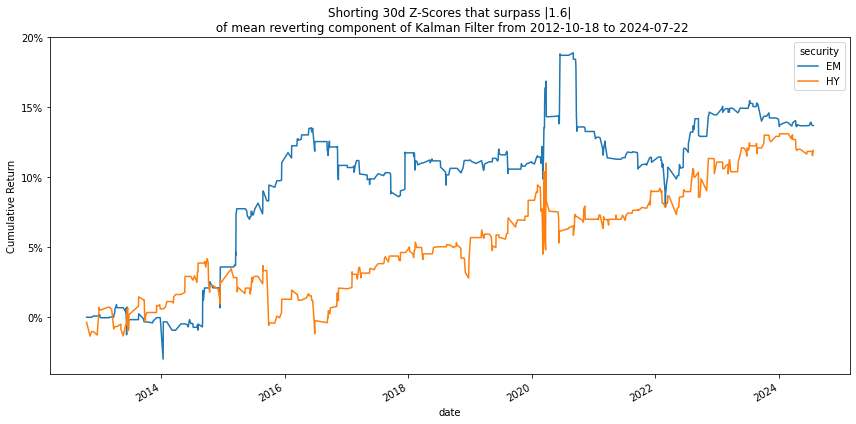

In [17]:
def plot_rolling_zscore(df_rolling_zscore: pd.DataFrame, lookback: int) -> plt.Figure:     

    _, axes = plt.subplots(figsize = (12,6))

    (df_rolling_zscore[
        ["date", "security", "rtn"]].
        pivot(index = "date", columns = "security", values = "rtn").
        fillna(0).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ylabel = "Cumulative Return",
            ax = axes,
            figsize = (12,6),
            title = "Shorting {}d Z-Scores that surpass |1.6|\n of mean reverting component of Kalman Filter from {} to {}".format(
                lookback,
                df_rolling_zscore.date.min().date(),
                df_rolling_zscore.date.max().date())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    plt.tight_layout()
    
plot_rolling_zscore(df_rolling_zscore, 30)

Not fully convinced that this strategy also works since the value 30 has been cherry-picked. Taking a 20% insample ratio and then comparing lookback windows to sharpe can give a good idea on if the alpha can actually be harnessed. Although this methodology proposes some backtesting biases such as reusing examples its more of a back-of-the-envolope calculation and a stronger approach than the one presented in the paper. 

In [18]:
def _get_is_sharpe(df: pd.DataFrame, is_ratio: float) -> pd.DataFrame: 

    cutoff_idx = int(len(df) * is_ratio) 
    df_out = (df.sort_values(
        "date").
        head(cutoff_idx).
        query("abs_zscore > 1.6")
        [["security", "rtn"]].
        groupby("security").
        agg(["mean", "std"])
        ["rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std": "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        drop(columns = ["security"]))
    
    return df_out

def get_is_sharpe(df_mean_reverting: pd.DataFrame, min_value: int = 2, max_value: int = 50, is_ratio: float = 0.2) -> pd.DataFrame: 

    lookback_windows = [i + min_value for i in range(max_value - 1)]
    df_strats = pd.concat([
        get_rolling_zscore(df_mean_reverting, window).assign(lookback_window = window) 
        for window in lookback_windows])

    df_sharpes = (df_strats.groupby(
        ["security", "lookback_window"]).
        apply(_get_is_sharpe, is_ratio).
        reset_index().
        drop(columns = ["level_2"]))
    
    return df_sharpes

df_sharpes = get_is_sharpe(df_mean_reverting)

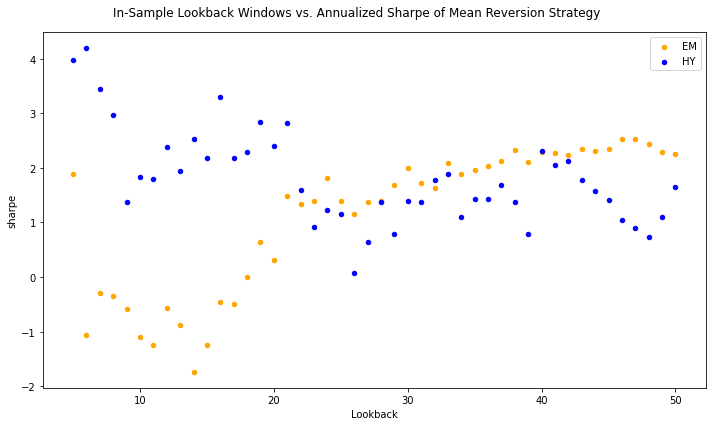

In [19]:
def plot_is_sharpes(df_sharpes: pd.DataFrame) -> plt.Figure:
    
    fig, axes = plt.subplots(figsize = (10,6))
    securities_dict = {
        "EM": "orange",
        "HY": "blue"}

    for security in list(securities_dict.keys()):

        (df_sharpes.query(
            "security == @security").
            plot(
                ax = axes,
                kind = "scatter",
                x = "lookback_window",
                y = "sharpe",
                xlabel = "Lookback",
                color = securities_dict[security],
                label = security))

    fig.suptitle("In-Sample Lookback Windows vs. Annualized Sharpe of Mean Reversion Strategy")
    plt.tight_layout()
    
plot_is_sharpes(df_sharpes)

The in-sample sharpes are pretty stable specifically for EM less for HY. 

In [20]:
def get_corr(df_rolling_zscore: pd.DataFrame, df_max_sharpe: pd.DataFrame) -> pd.DataFrame: 
    
    df_mean_reverting = (df_rolling_zscore.assign(
        strat_name = lambda x: x.security + "\n 30d Mean Reverting")
        [["date", "strat_name", "rtn"]])

    df_trend = (df_max_sharpe.query(
        "variable == 'smooth'").
        assign(strat_name = lambda x: x.security + "\n" + x.lookback.astype(str) + "d Trend")
        [["strat_name", "date", "signal_rtn"]].
        rename(columns = {"signal_rtn": "rtn"}))

    df_corr = (pd.concat([df_mean_reverting, df_trend]).
        rename(columns = {"strat_name": "Strategy"}).
        pivot(index = "date", columns = "Strategy", values = "rtn").
        fillna(0).
        corr())
    
    return df_corr

df_corr = get_corr(df_rolling_zscore, df_max_sharpe)

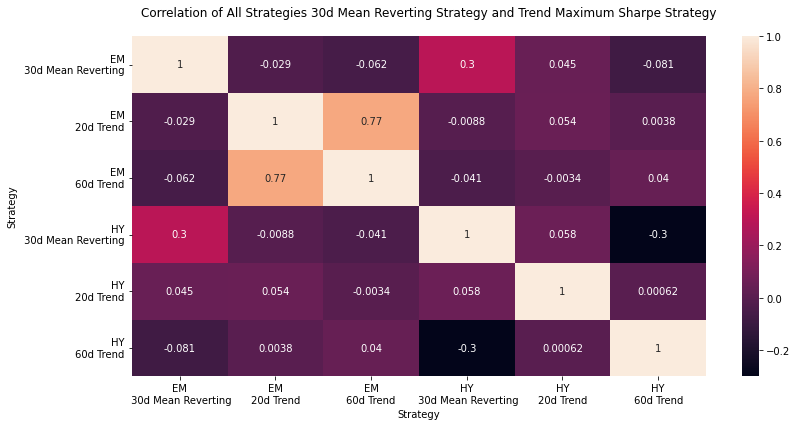

In [21]:
def plot_correlation_matrix(df_corr: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))

    sns.heatmap(
        df_corr, 
        annot = True,
        ax = axes)

    fig.suptitle("Correlation of All Strategies 30d Mean Reverting Strategy and Trend Maximum Sharpe Strategy")
    plt.tight_layout()
    
plot_correlation_matrix(df_corr)